In [1]:
cd ..

/home/ikboljonsobirov/uncertainty-benchmark/experiments


In [4]:
import medmnist
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
from models.models_mcd import ResNet18_MCD, ResNet50_MCD
from models.models import ResNet18, ResNet50

from acsconv.converters import ACSConverter, Conv2_5dConverter, Conv3dConverter
from utils.utils import Transform3D, model_to_syncbn
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import torch.nn.functional as F


In [7]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_flag = 'organmnist3d'
# data_flag = 'nodulemnist3d'

chkpt_paths = [
                '/home/ikboljonsobirov/uncertainty-benchmark/experiments/output/organmnist3d/231227_135255_resnet18/best_model.pth',
                '/home/ikboljonsobirov/uncertainty-benchmark/experiments/output/organmnist3d/240103_134558_resnet18_ens2/best_model.pth',
                '/home/ikboljonsobirov/uncertainty-benchmark/experiments/output/organmnist3d/240103_141610_resnet18_ens3/best_model.pth',
                '/home/ikboljonsobirov/uncertainty-benchmark/experiments/output/organmnist3d/240103_145942_resnet18_ens4/best_model.pth',
                '/home/ikboljonsobirov/uncertainty-benchmark/experiments/output/organmnist3d/240104_114930_resnet18_esn5/best_model.pth',
                ]

# chkpt_paths = [
#                 '/home/ikboljonsobirov/uncertainty-benchmark/experiments/output/nodulemnist3d/231227_142631_resnet18/best_model.pth',
#                 '/home/ikboljonsobirov/uncertainty-benchmark/experiments/output/organmnist3d/240103_134558_resnet18_ens2/best_model.pth',
#                 '/home/ikboljonsobirov/uncertainty-benchmark/experiments/output/organmnist3d/240103_141610_resnet18_ens3/best_model.pth',
#                 '/home/ikboljonsobirov/uncertainty-benchmark/experiments/output/organmnist3d/240103_145942_resnet18_ens4/best_model.pth',
#                 '/home/ikboljonsobirov/uncertainty-benchmark/experiments/output/organmnist3d/240104_114930_resnet18_esn5/best_model.pth',
#                 ]


download = True

NUM_EPOCHS = 3
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
n_channels = info['n_channels']
n_classes = len(info['label'])

# load the data
train_dataset = DataClass(split='train',  download=download)
val_dataset = DataClass(split='val',  download=download)
test_dataset = DataClass(split='test',  download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Using downloaded and verified file: /home/ikboljonsobirov/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/ikboljonsobirov/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/ikboljonsobirov/.medmnist/organmnist3d.npz


In [44]:
ensemble_models = []

for chkpt_path in chkpt_paths:
    # Instantiate the model
    model = ResNet18(in_channels=n_channels, num_classes=n_classes)
    model = model_to_syncbn(ACSConverter(model))

    model.to(device)  # Move model to appropriate device
    model = model.double()

    # Load the checkpoint
    model.load_state_dict(torch.load(chkpt_path)['net'])

    # Set the model to evaluation mode
    model.eval()

    # Add the model to the ensemble
    ensemble_models.append(model)


In [45]:
def ensemble_predictions(ensemble_models, data_loader):
    all_predictions = []

    for model in ensemble_models:
        model_predictions = []
        for data, _ in data_loader:
            data = data.to(device)
            output = model(data).detach().cpu().numpy()
            # print(output.shape)
            model_predictions.append(output)
            
        # print(len(model_predictions), model_predictions[0].shape)
        model_predictions = np.concatenate(model_predictions, axis=0)
        
        all_predictions.append(model_predictions)

    # Transpose to get predictions for each model per sample
    # all_predictions = np.array(all_predictions).transpose(1, 0, 2, 3)

    # Calculate mean and standard deviation across ensemble predictions
    # mean_predictions = np.mean(all_predictions, axis=1)
    # uncertainty = np.std(all_predictions, axis=1)
    
    return all_predictions


In [46]:
all_predictions = ensemble_predictions(ensemble_models, test_loader)


In [55]:
concatenated_output = np.array(all_predictions)
concatenated_output = F.softmax(torch.tensor(concatenated_output), dim=2)
concatenated_output.shape

torch.Size([5, 610, 11])

In [61]:
concatenated_output[0][0]

tensor([1.4318e-02, 8.7003e-09, 3.6550e-08, 5.3057e-08, 4.2797e-05, 2.0685e-01,
        5.1181e-05, 5.2474e-08, 2.1886e-06, 4.7293e-05, 7.7869e-01],
       dtype=torch.float64)

In [63]:
mc_mean, mc_uncertainty = torch.mean(concatenated_output, axis=0), torch.std(concatenated_output, axis=0)

In [77]:
mc_mean.shape, mc_uncertainty.shape

(torch.Size([610, 11]), (11,))

In [68]:
targets = []
for _, target in test_loader:
    target = target.numpy()
    print(target.shape)
    targets.append(target)

(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(2, 1)


In [69]:
targets  = np.concatenate(targets, axis=0)

In [70]:
total_f1 = f1_score(targets, np.argmax(mc_mean, axis=1), average='macro')
total_f1

0.9470556511672228

0 0.001 0.9393442622950819
6 0.01108080808080808 0.9437086092715232
12 0.021161616161616163 0.9481605351170569
19 0.031242424242424245 0.9560067681895094
25 0.041323232323232324 0.958974358974359
31 0.0514040404040404 0.9637305699481865
37 0.06148484848484849 0.9668411867364747
43 0.07156565656565657 0.9717813051146384
49 0.08164646464646465 0.9803921568627451
55 0.09172727272727273 0.9819819819819819
62 0.1018080808080808 0.9835766423357665
68 0.11188888888888888 0.9870848708487084
74 0.12196969696969698 0.9888059701492538
80 0.13205050505050506 0.9886792452830189
86 0.14213131313131314 0.9885496183206107
92 0.15221212121212122 0.9884169884169884
98 0.1622929292929293 0.98828125
105 0.17237373737373737 0.9881188118811881
111 0.18245454545454545 0.9899799599198397
117 0.19253535353535353 0.9898580121703854
123 0.2026161616161616 0.9917864476386037
129 0.2126969696969697 0.9937629937629938
135 0.22277777777777777 0.9936842105263158
142 0.23285858585858585 0.9935897435897436
148 0.242939

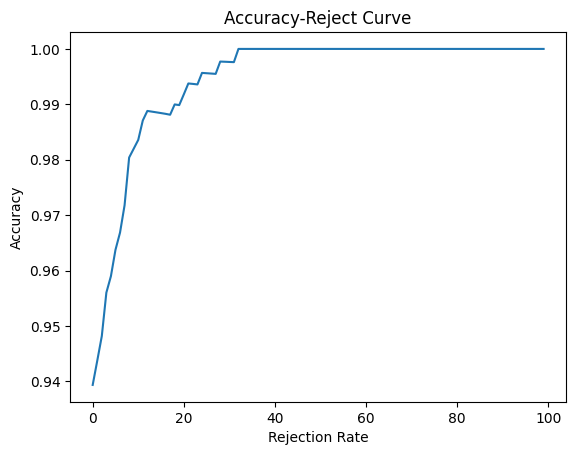

In [71]:
# Assuming predictions are the class with the highest mean probability
predicted_classes = mc_mean.argmax(axis=1)
predicted_class_uncertainty = mc_uncertainty[np.arange(len(mc_uncertainty)), predicted_classes]

# Assuming test_labels is a list or array of the true labels
test_labels = targets
accuracies = []
rejection_rates = np.linspace(0.001, 0.999, 100)

for rejection_rate in rejection_rates:
    num_reject = int(len(predicted_class_uncertainty) * rejection_rate)
    sorted_indices = np.argsort(predicted_class_uncertainty).numpy()[::-1]

    indices_to_keep = sorted_indices[num_reject:]
    
    selected_labels = test_labels[indices_to_keep]
    selected_predictions = predicted_classes.numpy()[indices_to_keep]
    
    accuracy = accuracy_score(selected_labels, selected_predictions)
    print(num_reject, rejection_rate, accuracy)

    accuracies.append(accuracy)

# Plotting the accuracy-reject curve
plt.plot(accuracies)
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve')
plt.show()


In [72]:
from sklearn.utils import resample

# Number of bootstrap samples
n_bootstraps = 1000

# Initialize list to store upper and lower bounds of uncertainty
lower_bounds = []
upper_bounds = []

for rejection_rate in rejection_rates:
    num_reject = int(len(predicted_class_uncertainty) * rejection_rate)
    indices_to_keep = np.argsort(predicted_class_uncertainty).numpy()[::-1][num_reject:]
    
    bootstrap_accuracies = []
    for _ in range(n_bootstraps):
        # Bootstrap sampling
        boot_indices = resample(indices_to_keep)
        boot_labels = targets[boot_indices]
        boot_predictions = predicted_classes.numpy()[boot_indices]

        # Calculate bootstrap accuracy
        boot_accuracy = accuracy_score(boot_labels, boot_predictions)
        bootstrap_accuracies.append(boot_accuracy)

    # Calculate the lower and upper bound of the uncertainty
    lower_bound = np.percentile(bootstrap_accuracies, 2.5)
    upper_bound = np.percentile(bootstrap_accuracies, 97.5)

    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)


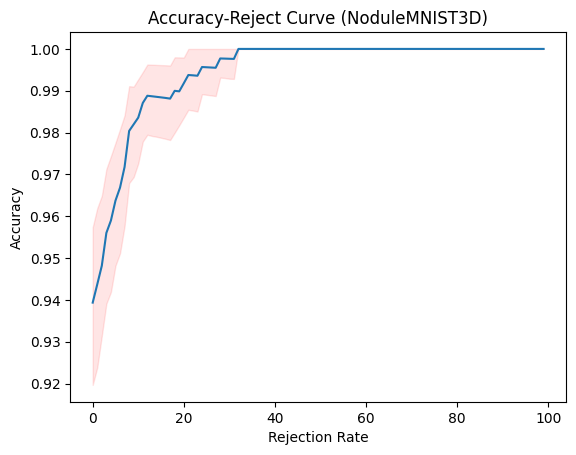

In [73]:
# draw the uncertainty interval
plt.plot(accuracies,label='Accuracy')
plt.fill_between(range(len(lower_bounds)), lower_bounds, upper_bounds, color='red', alpha=0.1, label='Uncertainty Region')
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve (OrganMNIST3D)')
plt.show()


### Use Entropy as the Uncertainty Metric

In [83]:
from scipy.stats import entropy

entropies = np.array([entropy(mean_prediction) for mean_prediction in mc_mean])


In [84]:
entropies.shape

(610,)

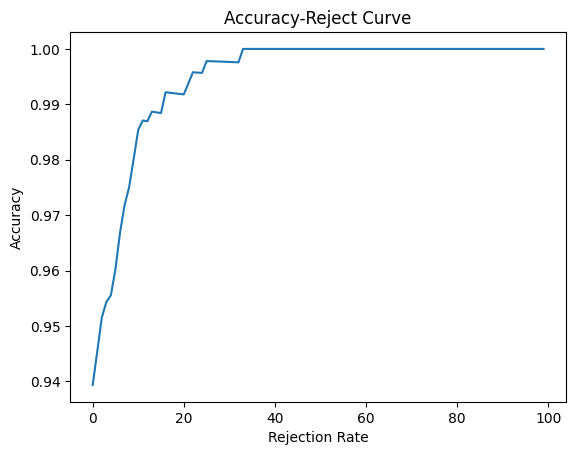

In [98]:
# Assuming predictions are the class with the highest mean probability
predicted_classes = mc_mean.argmax(axis=1)
# predicted_class_uncertainty = mc_uncertainty[np.arange(len(mc_uncertainty)), predicted_classes]

# Assuming test_labels is a list or array of the true labels
test_labels = targets
accuracies = []
rejection_rates = np.linspace(0.001, 0.999, 100)

for rejection_rate in rejection_rates:
    num_reject = int(len(entropies) * rejection_rate)
    sorted_indices = np.argsort(entropies)[::-1]

    indices_to_keep = sorted_indices[num_reject:]
    
    selected_labels = test_labels[indices_to_keep]
    selected_predictions = predicted_classes.numpy()[indices_to_keep]
    
    accuracy = accuracy_score(selected_labels, selected_predictions)
    # print(num_reject, rejection_rate, accuracy)

    accuracies.append(accuracy)

# Plotting the accuracy-reject curve
plt.plot(accuracies)
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve')
plt.show()


In [99]:
from sklearn.utils import resample

# Number of bootstrap samples
n_bootstraps = 1000

# Initialize list to store upper and lower bounds of uncertainty
lower_bounds = []
upper_bounds = []

for rejection_rate in rejection_rates:
    num_reject = int(len(entropies) * rejection_rate)
    indices_to_keep = np.argsort(entropies)[::-1][num_reject:]
    
    bootstrap_accuracies = []
    for _ in range(n_bootstraps):
        # Bootstrap sampling
        boot_indices = resample(indices_to_keep)
        boot_labels = targets[boot_indices]
        boot_predictions = predicted_classes.numpy()[boot_indices]

        # Calculate bootstrap accuracy
        boot_accuracy = accuracy_score(boot_labels, boot_predictions)
        bootstrap_accuracies.append(boot_accuracy)

    # Calculate the lower and upper bound of the uncertainty
    lower_bound = np.percentile(bootstrap_accuracies, 2.5)
    upper_bound = np.percentile(bootstrap_accuracies, 97.5)

    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)


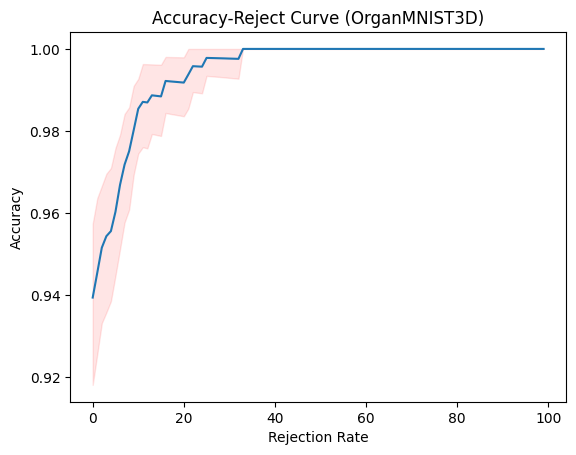

In [100]:
# draw the uncertainty interval
plt.plot(accuracies,label='Accuracy')
plt.fill_between(range(len(lower_bounds)), lower_bounds, upper_bounds, color='red', alpha=0.1, label='Uncertainty Region')
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve (OrganMNIST3D)')
plt.show()


### Use Confidence as the Uncertainty Metric

In [101]:
confidences = np.max(mc_mean.numpy(), axis=1)
confidences.shape

(610,)

609 0.001 0.9408866995073891
609 0.011070707070707071 0.9485903814262023
609 0.02114141414141414 0.9530988274706867
609 0.031212121212121212 0.9593220338983051
609 0.04128282828282828 0.964041095890411
609 0.05135353535353535 0.967128027681661
609 0.06142424242424242 0.9702797202797203
609 0.0714949494949495 0.9734982332155477
609 0.08156565656565656 0.9767857142857143
609 0.09163636363636363 0.9819494584837545
609 0.1017070707070707 0.9872029250457038
609 0.11177777777777778 0.9870609981515711
609 0.12184848484848484 0.9887850467289719
609 0.1319191919191919 0.9886578449905482
609 0.141989898989899 0.988527724665392
609 0.15206060606060606 0.988394584139265
609 0.16213131313131313 0.9882583170254403
609 0.1722020202020202 0.9920634920634921
609 0.18227272727272725 0.9919678714859438
609 0.19234343434343434 0.991869918699187
609 0.2024141414141414 0.9917695473251029
609 0.21248484848484847 0.9916666666666667
609 0.22255555555555556 0.9957805907172996
609 0.23262626262626263 0.995726495

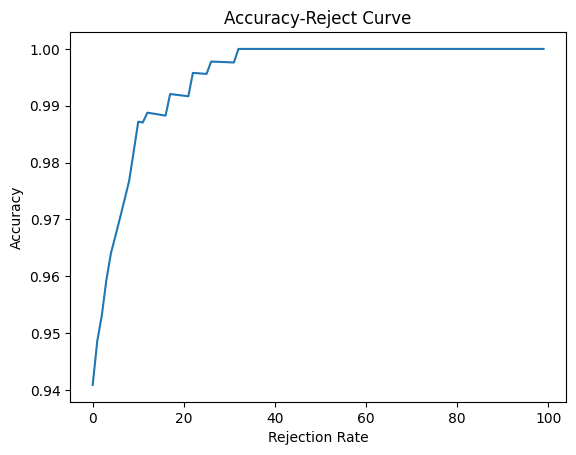

In [116]:
# Assuming predictions are the class with the highest mean probability
predicted_classes = mc_mean.argmax(axis=1)
# predicted_class_uncertainty = mc_uncertainty[np.arange(len(mc_uncertainty)), predicted_classes]

# Assuming test_labels is a list or array of the true labels
test_labels = targets
accuracies = []
rejection_rates = np.linspace(0.001, 0.998, 100)


for rejection_rate in rejection_rates:
    num_keep = int(len(confidences) * (1 - rejection_rate))
    indices_to_keep = np.argsort(confidences)[-num_keep:]

    # indices_to_keep = sorted_indices[num_keep:]
    
    selected_labels = test_labels[indices_to_keep]
    selected_predictions = np.argmax(mc_mean, axis=1)[indices_to_keep]
    
    accuracy = accuracy_score(selected_labels, selected_predictions)
    print(num_reject, rejection_rate, accuracy)

    accuracies.append(accuracy)

# Plotting the accuracy-reject curve
plt.plot(accuracies)
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve')
plt.show()


In [117]:
from sklearn.utils import resample

# Number of bootstrap samples
n_bootstraps = 1000

# Initialize list to store upper and lower bounds of uncertainty
lower_bounds = []
upper_bounds = []

for rejection_rate in rejection_rates:
    num_keep = int(len(confidences) * (1 - rejection_rate))
    indices_to_keep = np.argsort(confidences)[-num_keep:]
    
    bootstrap_accuracies = []
    for _ in range(n_bootstraps):
        # Bootstrap sampling
        boot_indices = resample(indices_to_keep)
        boot_labels = targets[boot_indices]
        boot_predictions = predicted_classes.numpy()[boot_indices]

        # Calculate bootstrap accuracy
        boot_accuracy = accuracy_score(boot_labels, boot_predictions)
        bootstrap_accuracies.append(boot_accuracy)

    # Calculate the lower and upper bound of the uncertainty
    lower_bound = np.percentile(bootstrap_accuracies, 2.5)
    upper_bound = np.percentile(bootstrap_accuracies, 97.5)

    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)


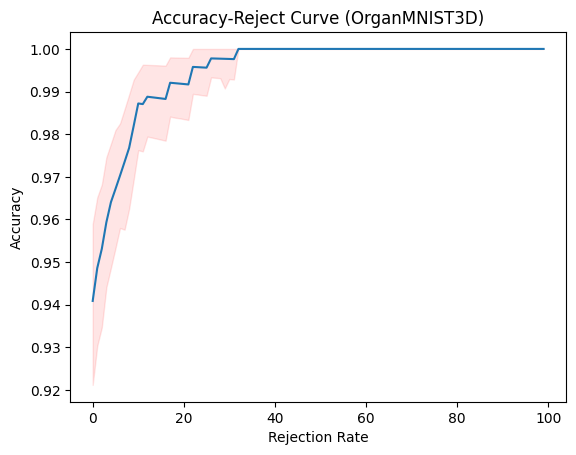

In [118]:
# draw the uncertainty interval
plt.plot(accuracies,label='Accuracy')
plt.fill_between(range(len(lower_bounds)), lower_bounds, upper_bounds, color='red', alpha=0.1, label='Uncertainty Region')
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve (OrganMNIST3D)')
plt.show()
